# Preparation

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, cut_tree

from counterfactualgp.gp import GP
from counterfactualgp.mean import LinearWithBsplinesBasis
from counterfactualgp.treatment import DummyTreatment, Treatment
from counterfactualgp.mpp import BinaryActionModel
from counterfactualgp.cov import iid_cov, se_cov, linear_cov
from counterfactualgp.bsplines import BSplines
from counterfactualgp.util import make_predict_samples, cluster_trajectories

In [2]:
with open('dataset/data_set_bspline_3classes.pkl', 'rb') as fin:
    data = pickle.load(fin)

In [3]:
low, high = data['xlim']
num_bases = 5
bsplines_degree = 3
n_clusters = len(data['class_prob'])
basis = BSplines(low, high, num_bases, bsplines_degree, boundaries='space')

#options = {'maxiter':1}
options = {}

In [4]:
def draw_bsplines(basis, coef):
    t = np.linspace(basis._low, basis._high, num=100)
    n_classes = len(coef)

    fig, axes = plt.subplots(nrows=1, ncols=n_classes, sharey=True, figsize=(4*n_classes, 4))
    for i,w in enumerate(coef):
        y = np.dot(basis.design(t), w)
        
        if isinstance(axes, np.ndarray): 
            axes[i].plot(t, y)
        else:
            axes.plot(t, y)

    plt.show()

In [5]:
def draw_samples(gp, samples, t_star, rx_star, nrow=3, ncol=3, title='',
                 truncated_time=None, exclude_ac=[]):
    fig, axes = plt.subplots(nrow, ncol, sharex=True, figsize=(12,6), sharey=True)
    _samples = make_predict_samples(samples[0:nrow*ncol], t_star, rx_star, truncated_time)
    for i in range(nrow):
        for j in range(ncol):
            idx = i*nrow+j
            y, x = samples[idx]
            t, rx = x
            _y, _x, _x_star = next(_samples)
            _t_star, _rx_star = _x_star
            
            # predict
            yhat, cov_hat = gp.predict(_x_star, _y, _x, exclude_ac)
            y_std = np.diag(cov_hat)
            
            # draw
            axes[i, j].plot(_t_star, yhat, color='b')
            axes[i, j].scatter(t, y, marker='o', color='r')
            for _tt, _rx in zip(t, rx):
                if _rx == 1:
                    axes[i, j].axvline(x=_tt, color = 'y')
            axes[i, j].fill_between(_t_star, yhat - y_std, yhat + y_std,
                                 alpha=0.2, color='k')
            if truncated_time is not None:
                axes[i, j].axvline(x=truncated_time, color='r', ls='--')
    fig.suptitle(title)
    plt.show()

In [6]:
def MSE(gp, samples, truncated_time, exclude_ac=[]):
    '''
    Calculate the MSE metric over points after `truncated_time`.
    '''
    _samples = make_predict_samples(samples, None, None, truncated_time)
    s = 0.0
    for (y, x), (_y, _x, _x_star) in zip(samples, _samples):
        yhat, cov_hat = gp.predict(_x_star, _y, _x, exclude_ac)
        
        _t_star, _rx_star = _x_star
        idx = _t_star > truncated_time
        s += np.sum((yhat - y)[idx] **2) / len(y[idx])

    return s / len(samples)

# Clustering

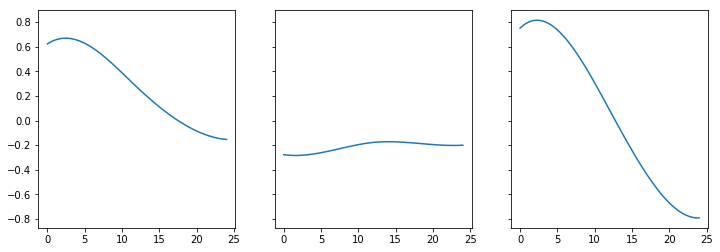

In [7]:
lmm, clustered_basis = cluster_trajectories(data['training2'], basis, n_clusters)
draw_bsplines(basis, clustered_basis)

# Mixture of GPs

## Mixture of BGPs without treatment

obj= 4180.713035349713
obj= 3948.043767123113
obj= 3906.748905639862
obj= 3883.8800845116157
obj= 3871.6121330418455
obj= 3865.6007564590004
obj= 3854.277498602188
obj= 3834.5641048293237
obj= 3804.1732153463067
obj= 3793.319247670745
obj= 3790.605336634552
obj= 3786.4773222392755
obj= 3778.616941443368
obj= 3765.1580911454103
obj= 3762.5089883795504
obj= 3740.6497466564547
obj= 3729.212624058689
obj= 3723.9309623522413
obj= 3722.48564685027
obj= 3722.016904511807
obj= 3721.9765113683598
obj= 3721.9656082306565
obj= 3721.9641959382975
obj= 3721.964073325483
obj= 3721.963887138663
obj= 3721.9638181011137
obj= 3721.9638160214254
obj= 3721.9638149232514
obj= 3721.9638148977997
obj= 3721.9638148798253
obj= 3721.9638148792556
obj= 3721.9638148790877
obj= 3721.9638148790864
obj= 3721.9638148790855
{'classes_prob_logit': array([ 0.0068658 , -0.12339793,  0.11653212]), 'ln_cov_w': array([-2.17312191]), 'linear_with_bsplines_basis_mean_coef2': array([-2.95282837,  2.43552787,  0.27649434, -0.16

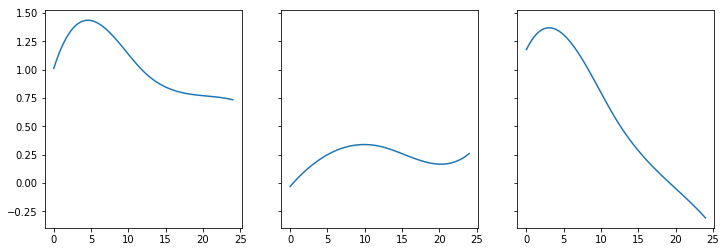

In [8]:
m = []
for i in range(n_clusters):
    m.append(LinearWithBsplinesBasis(basis, no=i, init=clustered_basis[i]))
tr = []
tr.append( (1.0, DummyTreatment()) )
mgp = GP(m, linear_cov(basis), tr, ac_fn=None)
mgp.fit(data['training2'], options=options)
print(mgp.params)

coef = [mgp.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef)

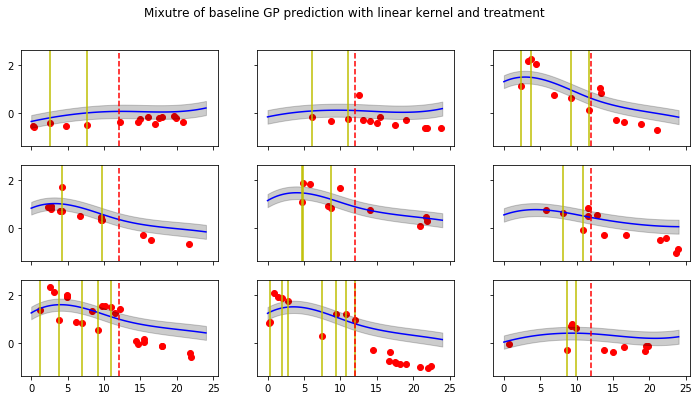

In [9]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of baseline GP prediction with linear kernel and treatment', 
             data['truncated_time'])

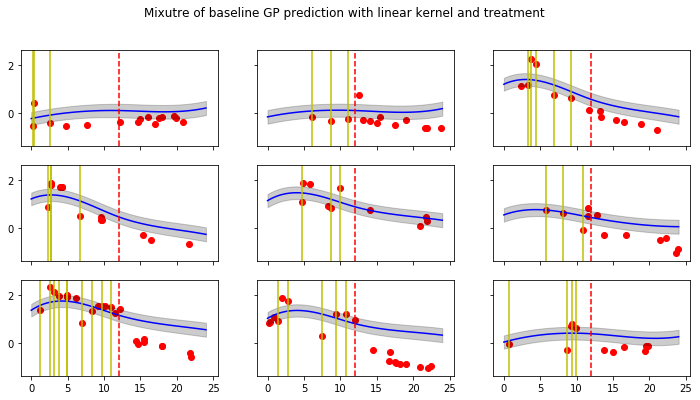

In [10]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mgp, data['testing2'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of baseline GP prediction with linear kernel and treatment', 
             data['truncated_time'])

## Mixture of BGPs with treatment

obj= 3847.8984307104897
obj= 2876.371756959828
obj= 2724.2024670600294
obj= 2688.279589353428
obj= 2627.547348709093
obj= 2510.7353047494794
obj= 2338.710976503167
obj= 2270.1290336326488
obj= 2244.3029396224465
obj= 2210.601285157464
obj= 2185.58917343808
obj= 2144.984313058031
obj= 2096.237838945198
obj= 2048.4686227083234
obj= 2013.5714167012482
obj= 1989.6032113826338
obj= 1960.9511073015854
obj= 1918.8099290903992
obj= 1895.3807664398273
obj= 1888.4937364779855
obj= 1887.2279908111786
obj= 1885.2995215083606
obj= 1883.12742424098
obj= 1881.8435356157875
obj= 1879.4824404328667
obj= 1875.5600984115931
obj= 1873.7952774571665
obj= 1865.461695795429
obj= 1849.6425164979191
obj= 1834.954237532157
obj= 1827.3303562831604
obj= 1817.4016997804206
obj= 1811.4364308143722
obj= 1807.2637096507249
obj= 1801.566804275007
obj= 1798.2814281113165
obj= 1793.4171180181863
obj= 1789.6506497364096
obj= 1789.2518986408068
obj= 1789.1877516912402
obj= 1789.1454339009924
obj= 1789.1331752564777
obj= 1

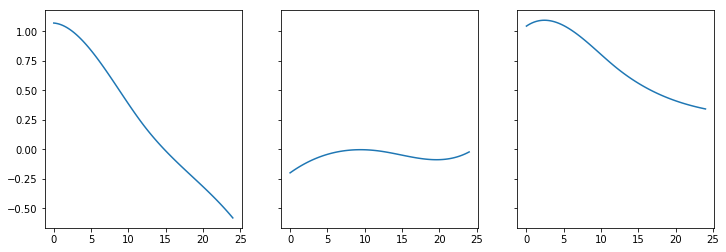

In [11]:
m = []
for i in range(n_clusters):
    m.append(LinearWithBsplinesBasis(basis, no=i, init=clustered_basis[i]))
tr = []
tr.append( (1.0, Treatment(2.0)) )
mgp_rx = GP(m, linear_cov(basis), tr, ac_fn=None)
mgp_rx.fit(data['training2'], options=options)
print(mgp_rx.params)

coef = [mgp_rx.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef)

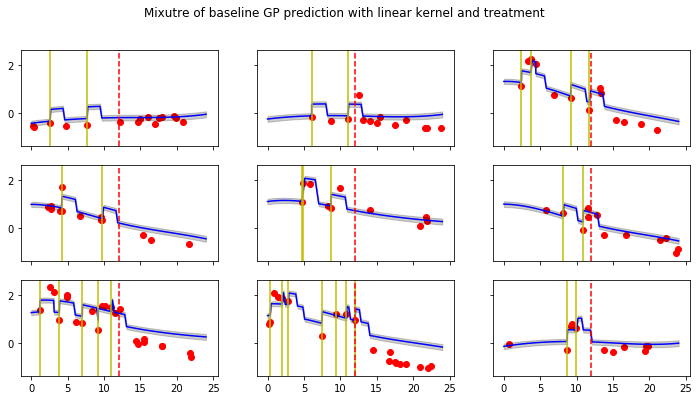

In [12]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mgp_rx, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of baseline GP prediction with linear kernel and treatment', 
             data['truncated_time'])

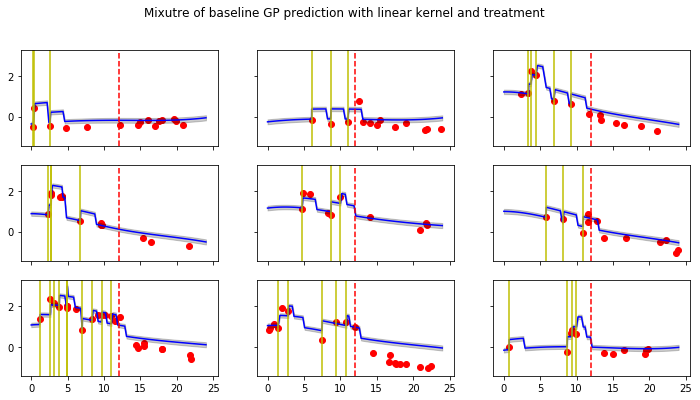

In [13]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mgp_rx, data['testing2'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of baseline GP prediction with linear kernel and treatment', 
             data['truncated_time'])

## Mixture of CGPs

obj= [6735.41840013]
obj= [5608.61993632]
obj= [5321.26370878]
obj= [5177.20103384]
obj= [5053.11760526]
obj= [5045.19074919]
obj= [5041.26694013]
obj= [5036.09136659]
obj= [5034.55384476]
obj= [5031.96317532]
obj= [5027.62416855]
obj= [5020.722376]
obj= [5014.60325507]
obj= [5007.36820224]
obj= [5005.18840103]
obj= [5001.31359535]
obj= [4994.00853241]
obj= [4981.59057203]
obj= [4964.44547526]
obj= [4960.76117326]
obj= [4958.78103344]
obj= [4958.60436852]
obj= [4958.52308097]
obj= [4958.5136518]
obj= [4958.50215449]
obj= [4958.49972955]
obj= [4958.49955675]
obj= [4958.49951461]
obj= [4958.49950859]
obj= [4958.49950778]
obj= [4958.49950773]
obj= [4958.49950772]
obj= [4958.49950772]
obj= [4958.49950772]
obj= [4958.49950772]
obj= [4958.49950772]
obj= [4958.49950772]
{'classes_prob_logit': array([ 0.09176957, -0.16476873,  0.07299915]), 'effects_window_F': array([2.]), 'treatment': array([0.52022119]), 'ln_cov_w': array([-2.63768551]), 'action': array([0.38688449]), 'linear_with_bsplines_b

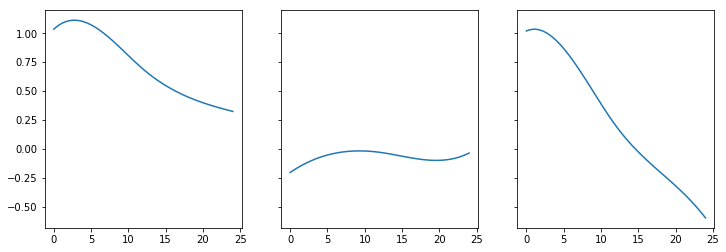

In [14]:
m = []
for i in range(n_clusters):
    m.append(LinearWithBsplinesBasis(basis, no=i, init=clustered_basis[i]))
tr = []
tr.append( (0.0, DummyTreatment()) )
tr.append( (1.0, Treatment(2.0)) )
ac = BinaryActionModel()
mcgp = GP(m, linear_cov(basis), tr, ac_fn=ac)
mcgp.fit(data['training2'], options=options)
print(mcgp.params)

coef = [mcgp.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef)

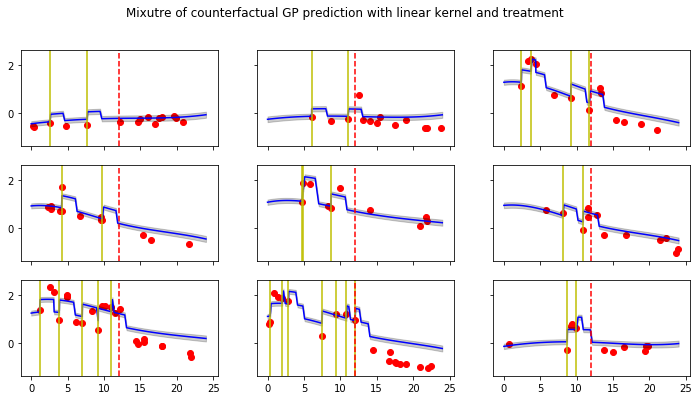

In [15]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mcgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of counterfactual GP prediction with linear kernel and treatment', 
             data['truncated_time'])

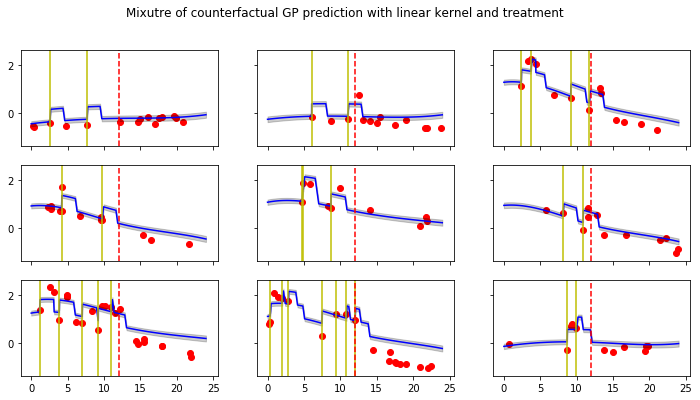

In [16]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mcgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of counterfactual GP prediction with linear kernel and treatment', 
             data['truncated_time'], exclude_ac=[0])

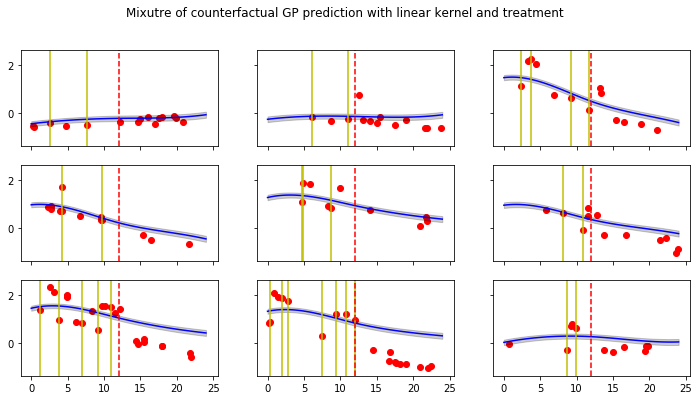

In [17]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mcgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of counterfactual GP prediction with linear kernel and treatment', 
             data['truncated_time'], exclude_ac=[1])

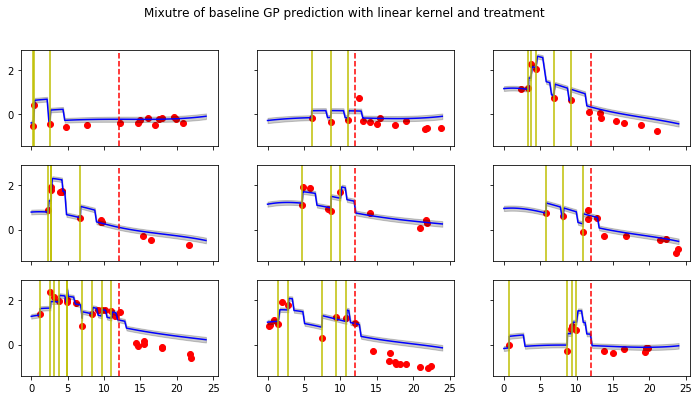

In [18]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mcgp, data['testing2'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of baseline GP prediction with linear kernel and treatment', 
             data['truncated_time'])

# Parameters Checking

In [19]:
def post_class_acc(gp, class_map_to_origin, classes):
    classes_hat = []
    for y, x in data['testing1']:
        ln_p_a, ln_p_mix = gp.class_posterior(y, x)
        p_mix = np.exp(ln_p_mix)
        c = class_map_to_origin[np.argmax(p_mix)]
        classes_hat.append(c)
    classes_hat = np.array(classes_hat)
    
    return np.sum(classes == classes_hat) / classes.shape[0]

In [28]:
class_map_to_origin = np.array([1, 2, 0])
post_class_acc(mgp, class_map_to_origin, data['classes'][data['n_train']:])

0.73

In [29]:
class_map_to_origin = np.array([0, 2, 1])
post_class_acc(mgp_rx, class_map_to_origin, data['classes'][data['n_train']:])

0.955

In [30]:
class_map_to_origin = np.array([1, 2, 0])
post_class_acc(mcgp, class_map_to_origin, data['classes'][data['n_train']:])

0.955

In [23]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
_samples = make_predict_samples(data['testing1'], t_star, rx_star, data['truncated_time'])
for i, (s, _s) in enumerate(zip(data['testing1'], _samples)):
    y, x = s
    _y, _x, _x_star = _s
            
    p_a, p_mix = mcgp.class_posterior(_y, _x)
    print(p_a, p_mix)
    
    if i == 9: break

[0.40446752 0.59553248] [1.74798537e-10 9.99999993e-01 6.62318218e-09]
[0.40446752 0.59553248] [6.31065356e-05 9.89767488e-01 1.01694053e-02]
[3.32160836e-05 9.99966784e-01] [2.23577332e-01 1.43385091e-09 7.76422667e-01]
[0.02265012 0.97734988] [1.69626726e-01 7.05702578e-05 8.30302704e-01]
[0.00112222 0.99887778] [8.55372151e-01 3.81503666e-06 1.44624034e-01]
[0.12274819 0.87725181] [0.09270056 0.0322186  0.87508084]
[6.70805360e-08 9.99999933e-01] [8.36397939e-01 8.71169761e-11 1.63602061e-01]
[1.17852567e-05 9.99988215e-01] [3.97332455e-01 1.18670423e-08 6.02667533e-01]
[0.00492777 0.99507223] [7.54272602e-04 9.89211914e-01 1.00338129e-02]
[0.00205769 0.99794231] [1.26343127e-01 1.00954432e-04 8.73555918e-01]


# MSE

In [32]:
for s,gp in zip(['mbgp', 'mbgp_rx', 'mcgp'], 
                 [mgp, mgp_rx, mcgp]):
    print(s, MSE(gp, data['testing1'], data['truncated_time']))

mbgp 0.29022680620251856
mbgp_rx 0.12736518645657663
mcgp 0.11846714255912666


In [33]:
for s, gp in zip(['mbgp', 'mbgp_rx', 'mcgp'], 
                 [mgp, mgp_rx, mcgp]):
    print(s, MSE(gp, data['testing2'], data['truncated_time']))

mbgp 0.33757746893828616
mbgp_rx 0.13405916217620595
mcgp 0.1316750654923154


In [34]:
print('mcgp', MSE(mcgp, data['testing1'], data['truncated_time'], exclude_ac=[]))
print('mcgp', MSE(mcgp, data['testing1'], data['truncated_time'], exclude_ac=[0]))
print('mcgp', MSE(mcgp, data['testing1'], data['truncated_time'], exclude_ac=[1]))

mcgp 0.11846714255912666
mcgp 0.11612459164585838
mcgp 0.25235452599875363
